<a href="https://colab.research.google.com/github/amedyukhina/AgrifieldNet/blob/main/landslidenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Landslide Prevention and Innovation Challenge

## Install and import dependencies

In [1]:
%%writefile requirements.txt

monai==0.9.1

Overwriting requirements.txt


In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import os
import pandas as pd
from skimage import io
import pylab as plt
from tqdm import tqdm
import re
import torch
import torch.utils.data
from torch import nn
from torchvision import transforms as torch_transforms
from monai.networks.nets import DenseNet
from sklearn.metrics import f1_score
from google.colab import files

In [4]:
random_seed = 42

## Load and transform training data

In [5]:
# upload training data
if not os.path.exists('Train.csv'):
    uploaded = files.upload()

In [6]:
# upload test data
if not os.path.exists('Test.csv'):
    uploaded = files.upload()

In [7]:
# Read files to pandas dataframes
df = pd.read_csv('Train.csv')

In [8]:
def transform_table(df):
    features = np.array([re.findall('(\d+)_(.+)', c)[0] for c in df.columns 
            if len(re.findall('(\d+)_(.+)', c)) > 0]).transpose()
    unique_cells = np.unique(features[0])
    unique_features = np.unique(features[1])
    df['id'] = df.index
    # move the features to rows
    df = pd.wide_to_long(df, list(unique_cells), i="id", 
                     j="feature", sep='_', suffix='\w+').reset_index()
    # move the cells to rows
    df = df.melt(id_vars=['feature', 'Sample_ID', 'Label'], 
        value_vars=list(unique_cells),
        var_name='cell', value_name='feature_value')
    
    # convert cell ids to int and sort
    df['cell'] = np.int_(df['cell'])
    df = df.sort_values(['Sample_ID', 'cell']).reset_index(drop=True)
    
    # move features back to columns
    df = df.pivot(index=['Sample_ID', 'cell', 'Label'], 
         columns='feature', values='feature_value').reset_index()
    df.columns.name = None
    
    return df

In [9]:
df = transform_table(df)
df.head()

,Sample_ID,cell,Label,aspect,elevation,geology,lsfactor,placurv,procurv,sdoif,slope,twi
0,1,1,0,98.1301,130.0,3.0,8.045186,0.038514,0.013903,1.281767,35.26439,3.173340
1,1,2,0,113.1986,129.0,3.0,8.333038,0.029463,0.014674,1.281743,37.29208,2.961406
2,1,3,0,116.5650,127.0,3.0,7.819405,0.031405,0.018249,1.281708,33.85452,3.315935
3,1,4,0,123.6901,126.0,3.0,8.032228,0.025771,0.018368,1.281684,35.79576,3.061250
4,1,5,0,135.0000,123.0,3.0,9.818933,0.010453,0.003341,1.281649,40.31554,3.246914


## Split into train and validation

In [10]:
val_fraction = 0.2

In [11]:
np.random.seed(random_seed)

In [12]:
ind = np.unique(df['Sample_ID'])
np.random.shuffle(ind)

In [13]:
n_val = int(val_fraction * len(ind))
n_val

2172

In [14]:
df_train = df[df['Sample_ID'].isin(ind[n_val:])].reset_index(drop=True)
df_val = df[df['Sample_ID'].isin(ind[:n_val])].reset_index(drop=True)

In [15]:
weights = df_train.groupby(['Label']).count()['Sample_ID'].values
weights = np.max(weights) / weights
weights

array([1.        , 3.02407407])

## Set up data pipeline

In [16]:
batch_size = 64

In [17]:
class DatasetTrain(torch.utils.data.Dataset):

    def __init__(self, df, transforms=None):
        self.df = df
        self.sample_ids = np.unique(df['Sample_ID'])
        self.features = [c for c in df.columns if not c in ['Sample_ID', 'cell', 'Label']]
        self.transforms = transforms

    def __getitem__(self, index):
        data = self.df[self.df['Sample_ID'] == self.sample_ids[index]]
        label = torch.tensor(data['Label'].iloc[0], dtype=torch.int64)
        data = data[self.features].values
        data = data.transpose()
        data = torch.tensor(data.reshape((-1, 5, 5)), dtype=torch.float64)

        if self.transforms:
            seed = np.random.randint(np.iinfo('int32').max)
            torch.manual_seed(seed)
            data = self.transforms(data)

        return data.float(), label, self.sample_ids[index]


    def __len__(self):
        return len(self.sample_ids)

In [18]:
train_val_transforms = torch_transforms.Compose([
        torch_transforms.Resize(125),
        torch_transforms.RandomHorizontalFlip(),
        torch_transforms.RandomVerticalFlip(),
    ])
test_transforms = torch_transforms.Compose([
        torch_transforms.Resize(125)
    ])

In [19]:
np.random.seed(random_seed)
dl_train = torch.utils.data.DataLoader(
    DatasetTrain(df_train, transforms=train_val_transforms), 
    shuffle=True, batch_size=batch_size, num_workers=2
    )
dl_val = torch.utils.data.DataLoader(
    DatasetTrain(df_val, transforms=train_val_transforms), 
    shuffle=False, batch_size=batch_size, num_workers=2
    )

## Specify training pipeline

In [20]:
lr = 0.0001
weight_decay = 0.0005
factor = 0.1
patience = 5
epochs = 100

In [21]:
net = DenseNet(spatial_dims=2, 
               in_channels=len([c for c in df_train.columns 
                                if not c in ['Sample_ID', 'cell', 'Label']]), 
               out_channels=2).cuda()

In [22]:
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weights).float()).cuda()
optimizer = torch.optim.AdamW(
    params=[{"params": [p for p in net.parameters() if p.requires_grad]}],
            lr=lr, weight_decay=weight_decay
            )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=factor, patience=patience
    )

In [23]:
def train_epoch(net, loss_fn, dl_train, optimizer):
    net.train()
    loss_fn.train()
    epoch_loss = 0
    step = 0
    for imgs, targets, ids in tqdm(dl_train):
        step += 1
        optimizer.zero_grad()
        outputs = net(imgs.cuda())
        losses = loss_fn(outputs, targets.cuda())
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()
        epoch_loss /= step
        return epoch_loss

In [24]:
def validate_epoch(net, loss_fn, dl_val):
    net.eval()
    loss_fn.eval()
    epoch_loss = 0
    step = 0

    metric = 0
    with torch.no_grad():
        for imgs, targets, ids in tqdm(dl_val):
            step += 1
            outputs = net(imgs.cuda())
            losses = loss_fn(outputs, targets.cuda())
            epoch_loss += losses.item()
            metric += f1_score(outputs.argmax(1).cpu().numpy(), 
                               targets.cpu().numpy())
        epoch_loss /= step
        metric /= step
    return epoch_loss, metric

## Train

In [25]:
%%time
best_metric = 0
train_losses = []
val_losses = []
val_metrics = []
for epoch in range(epochs):
    # training pass
    train_loss = train_epoch(net, loss_fn, dl_train, optimizer)

    # validation pass
    val_loss, val_metric = validate_epoch(net, loss_fn, dl_val)

    # update learning rate
    lr_scheduler.step(val_loss)

    # output
    print(f"epoch {epoch + 1} training loss: {train_loss:.4f}; "
          f"validation loss: {val_loss:.4f}; F1 Score: {val_metric:.4f}; "
          f"lr: {optimizer.param_groups[0]['lr']}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_metrics.append(val_metric)
    if val_metric >= best_metric:
        best_metric = val_metric
        torch.save(net.state_dict(), 'model.pth')
        print('saving best model')

100%|██████████| 34/34 [00:09<00:00,  3.63it/s]


epoch 1 training loss: 0.7898; validation loss: 0.8758; F1 Score: 0.4037; lr: 0.0001
saving best model


100%|██████████| 34/34 [00:05<00:00,  5.76it/s]


epoch 2 training loss: 0.8421; validation loss: 0.7608; F1 Score: 0.0057; lr: 0.0001


100%|██████████| 34/34 [00:05<00:00,  6.43it/s]


epoch 3 training loss: 0.7440; validation loss: 0.9222; F1 Score: 0.0278; lr: 0.0001


100%|██████████| 34/34 [00:05<00:00,  6.33it/s]


epoch 4 training loss: 0.6861; validation loss: 1.0640; F1 Score: 0.0515; lr: 0.0001


100%|██████████| 34/34 [00:06<00:00,  5.64it/s]


epoch 5 training loss: 0.7643; validation loss: 1.0879; F1 Score: 0.1037; lr: 0.0001


100%|██████████| 34/34 [00:05<00:00,  5.88it/s]


epoch 6 training loss: 0.6430; validation loss: 1.0515; F1 Score: 0.1498; lr: 0.0001


100%|██████████| 34/34 [00:05<00:00,  6.38it/s]


epoch 7 training loss: 0.6962; validation loss: 0.9846; F1 Score: 0.2177; lr: 0.0001


100%|██████████| 34/34 [00:05<00:00,  6.44it/s]


epoch 8 training loss: 0.7027; validation loss: 0.8809; F1 Score: 0.2770; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.36it/s]


epoch 9 training loss: 0.7443; validation loss: 0.8116; F1 Score: 0.3355; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.30it/s]


epoch 10 training loss: 0.6755; validation loss: 0.7677; F1 Score: 0.3641; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.44it/s]


epoch 11 training loss: 0.6879; validation loss: 0.7335; F1 Score: 0.3859; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.30it/s]


epoch 12 training loss: 0.7153; validation loss: 0.7122; F1 Score: 0.4036; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.37it/s]


epoch 13 training loss: 0.6445; validation loss: 0.6957; F1 Score: 0.4244; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.35it/s]


epoch 14 training loss: 0.6245; validation loss: 0.6873; F1 Score: 0.4280; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:06<00:00,  4.91it/s]


epoch 15 training loss: 0.5913; validation loss: 0.6784; F1 Score: 0.4350; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.34it/s]


epoch 16 training loss: 0.6565; validation loss: 0.6735; F1 Score: 0.4407; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.30it/s]


epoch 17 training loss: 0.6749; validation loss: 0.6679; F1 Score: 0.4431; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.25it/s]


epoch 18 training loss: 0.6282; validation loss: 0.6649; F1 Score: 0.4457; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.29it/s]


epoch 19 training loss: 0.6083; validation loss: 0.6622; F1 Score: 0.4469; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.39it/s]


epoch 20 training loss: 0.6296; validation loss: 0.6601; F1 Score: 0.4489; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.32it/s]


epoch 21 training loss: 0.6418; validation loss: 0.6565; F1 Score: 0.4531; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.38it/s]


epoch 22 training loss: 0.6591; validation loss: 0.6543; F1 Score: 0.4494; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.36it/s]


epoch 23 training loss: 0.5924; validation loss: 0.6516; F1 Score: 0.4549; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.39it/s]


epoch 24 training loss: 0.6770; validation loss: 0.6491; F1 Score: 0.4590; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.31it/s]


epoch 25 training loss: 0.6255; validation loss: 0.6476; F1 Score: 0.4573; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.37it/s]


epoch 26 training loss: 0.6768; validation loss: 0.6458; F1 Score: 0.4567; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.33it/s]


epoch 27 training loss: 0.6010; validation loss: 0.6458; F1 Score: 0.4557; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.31it/s]


epoch 28 training loss: 0.5716; validation loss: 0.6439; F1 Score: 0.4605; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.30it/s]


epoch 29 training loss: 0.5700; validation loss: 0.6422; F1 Score: 0.4612; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.23it/s]


epoch 30 training loss: 0.5961; validation loss: 0.6407; F1 Score: 0.4651; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:06<00:00,  5.27it/s]


epoch 31 training loss: 0.5754; validation loss: 0.6387; F1 Score: 0.4691; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.35it/s]


epoch 32 training loss: 0.6786; validation loss: 0.6376; F1 Score: 0.4702; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.32it/s]


epoch 33 training loss: 0.6140; validation loss: 0.6373; F1 Score: 0.4652; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.38it/s]


epoch 34 training loss: 0.7205; validation loss: 0.6380; F1 Score: 0.4672; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.28it/s]


epoch 35 training loss: 0.5806; validation loss: 0.6368; F1 Score: 0.4670; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.33it/s]


epoch 36 training loss: 0.6004; validation loss: 0.6361; F1 Score: 0.4717; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.37it/s]


epoch 37 training loss: 0.6517; validation loss: 0.6353; F1 Score: 0.4663; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.26it/s]


epoch 38 training loss: 0.6152; validation loss: 0.6368; F1 Score: 0.4647; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.33it/s]


epoch 39 training loss: 0.6675; validation loss: 0.6354; F1 Score: 0.4722; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.35it/s]


epoch 40 training loss: 0.5678; validation loss: 0.6334; F1 Score: 0.4774; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.29it/s]


epoch 41 training loss: 0.6257; validation loss: 0.6334; F1 Score: 0.4722; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.35it/s]


epoch 42 training loss: 0.5952; validation loss: 0.6318; F1 Score: 0.4714; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.30it/s]


epoch 43 training loss: 0.6368; validation loss: 0.6340; F1 Score: 0.4707; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.20it/s]


epoch 44 training loss: 0.5991; validation loss: 0.6329; F1 Score: 0.4737; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.31it/s]


epoch 45 training loss: 0.5799; validation loss: 0.6329; F1 Score: 0.4783; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.34it/s]


epoch 46 training loss: 0.6215; validation loss: 0.6311; F1 Score: 0.4729; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.29it/s]


epoch 47 training loss: 0.5770; validation loss: 0.6289; F1 Score: 0.4775; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.36it/s]


epoch 48 training loss: 0.5938; validation loss: 0.6300; F1 Score: 0.4737; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.23it/s]


epoch 49 training loss: 0.6952; validation loss: 0.6313; F1 Score: 0.4780; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.27it/s]


epoch 50 training loss: 0.6029; validation loss: 0.6306; F1 Score: 0.4743; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.33it/s]


epoch 51 training loss: 0.6100; validation loss: 0.6287; F1 Score: 0.4804; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.37it/s]


epoch 52 training loss: 0.6718; validation loss: 0.6292; F1 Score: 0.4778; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.21it/s]


epoch 53 training loss: 0.6627; validation loss: 0.6285; F1 Score: 0.4775; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.34it/s]


epoch 54 training loss: 0.5943; validation loss: 0.6273; F1 Score: 0.4733; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.37it/s]


epoch 55 training loss: 0.6486; validation loss: 0.6290; F1 Score: 0.4786; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.29it/s]


epoch 56 training loss: 0.7297; validation loss: 0.6297; F1 Score: 0.4710; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.26it/s]


epoch 57 training loss: 0.5660; validation loss: 0.6283; F1 Score: 0.4766; lr: 1e-05


100%|██████████| 34/34 [00:06<00:00,  5.35it/s]


epoch 58 training loss: 0.5627; validation loss: 0.6286; F1 Score: 0.4725; lr: 1e-05


100%|██████████| 34/34 [00:05<00:00,  6.34it/s]


epoch 59 training loss: 0.7232; validation loss: 0.6276; F1 Score: 0.4821; lr: 1e-05
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.40it/s]


epoch 60 training loss: 0.7314; validation loss: 0.6285; F1 Score: 0.4765; lr: 1.0000000000000002e-06


100%|██████████| 34/34 [00:05<00:00,  6.27it/s]


epoch 61 training loss: 0.6003; validation loss: 0.6276; F1 Score: 0.4756; lr: 1.0000000000000002e-06


100%|██████████| 34/34 [00:05<00:00,  6.48it/s]


epoch 62 training loss: 0.5664; validation loss: 0.6300; F1 Score: 0.4761; lr: 1.0000000000000002e-06


100%|██████████| 34/34 [00:05<00:00,  6.31it/s]


epoch 63 training loss: 0.6263; validation loss: 0.6277; F1 Score: 0.4782; lr: 1.0000000000000002e-06


100%|██████████| 34/34 [00:05<00:00,  6.33it/s]


epoch 64 training loss: 0.6110; validation loss: 0.6273; F1 Score: 0.4849; lr: 1.0000000000000002e-06
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.35it/s]


epoch 65 training loss: 0.5976; validation loss: 0.6279; F1 Score: 0.4776; lr: 1.0000000000000002e-06


100%|██████████| 34/34 [00:05<00:00,  6.38it/s]


epoch 66 training loss: 0.6405; validation loss: 0.6285; F1 Score: 0.4811; lr: 1.0000000000000002e-07


100%|██████████| 34/34 [00:05<00:00,  6.25it/s]


epoch 67 training loss: 0.6683; validation loss: 0.6281; F1 Score: 0.4789; lr: 1.0000000000000002e-07


100%|██████████| 34/34 [00:05<00:00,  6.29it/s]


epoch 68 training loss: 0.6073; validation loss: 0.6273; F1 Score: 0.4789; lr: 1.0000000000000002e-07


100%|██████████| 34/34 [00:05<00:00,  6.18it/s]


epoch 69 training loss: 0.6153; validation loss: 0.6260; F1 Score: 0.4772; lr: 1.0000000000000002e-07


100%|██████████| 34/34 [00:05<00:00,  6.23it/s]


epoch 70 training loss: 0.6118; validation loss: 0.6267; F1 Score: 0.4804; lr: 1.0000000000000002e-07


100%|██████████| 34/34 [00:05<00:00,  6.40it/s]


epoch 71 training loss: 0.5449; validation loss: 0.6247; F1 Score: 0.4866; lr: 1.0000000000000002e-07
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.27it/s]


epoch 72 training loss: 0.6677; validation loss: 0.6236; F1 Score: 0.4881; lr: 1.0000000000000002e-07
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.27it/s]


epoch 73 training loss: 0.6598; validation loss: 0.6234; F1 Score: 0.4854; lr: 1.0000000000000002e-07


100%|██████████| 34/34 [00:05<00:00,  6.29it/s]


epoch 74 training loss: 0.6766; validation loss: 0.6238; F1 Score: 0.4857; lr: 1.0000000000000002e-07


100%|██████████| 34/34 [00:05<00:00,  6.33it/s]


epoch 75 training loss: 0.6033; validation loss: 0.6256; F1 Score: 0.4896; lr: 1.0000000000000002e-07
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.38it/s]


epoch 76 training loss: 0.6439; validation loss: 0.6242; F1 Score: 0.4856; lr: 1.0000000000000002e-07


100%|██████████| 34/34 [00:05<00:00,  6.30it/s]


epoch 77 training loss: 0.5614; validation loss: 0.6249; F1 Score: 0.4829; lr: 1.0000000000000002e-07


100%|██████████| 34/34 [00:05<00:00,  6.25it/s]


epoch 78 training loss: 0.6574; validation loss: 0.6249; F1 Score: 0.4837; lr: 1.0000000000000002e-07


100%|██████████| 34/34 [00:05<00:00,  6.33it/s]


epoch 79 training loss: 0.6067; validation loss: 0.6226; F1 Score: 0.4853; lr: 1.0000000000000002e-07


100%|██████████| 34/34 [00:05<00:00,  6.43it/s]


epoch 80 training loss: 0.6149; validation loss: 0.6251; F1 Score: 0.4886; lr: 1.0000000000000002e-07


100%|██████████| 34/34 [00:05<00:00,  6.28it/s]


epoch 81 training loss: 0.6074; validation loss: 0.6263; F1 Score: 0.4825; lr: 1.0000000000000002e-07


100%|██████████| 34/34 [00:05<00:00,  6.26it/s]


epoch 82 training loss: 0.5976; validation loss: 0.6279; F1 Score: 0.4829; lr: 1.0000000000000002e-07


100%|██████████| 34/34 [00:05<00:00,  6.25it/s]


epoch 83 training loss: 0.6503; validation loss: 0.6256; F1 Score: 0.4884; lr: 1.0000000000000002e-07


100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


epoch 84 training loss: 0.6752; validation loss: 0.6271; F1 Score: 0.4867; lr: 1.0000000000000002e-07


100%|██████████| 34/34 [00:05<00:00,  6.30it/s]


epoch 85 training loss: 0.6888; validation loss: 0.6256; F1 Score: 0.4853; lr: 1.0000000000000004e-08


100%|██████████| 34/34 [00:05<00:00,  6.37it/s]


epoch 86 training loss: 0.6024; validation loss: 0.6276; F1 Score: 0.4817; lr: 1.0000000000000004e-08


100%|██████████| 34/34 [00:05<00:00,  6.21it/s]


epoch 87 training loss: 0.5984; validation loss: 0.6274; F1 Score: 0.4798; lr: 1.0000000000000004e-08


100%|██████████| 34/34 [00:05<00:00,  6.32it/s]


epoch 88 training loss: 0.5880; validation loss: 0.6271; F1 Score: 0.4852; lr: 1.0000000000000004e-08


100%|██████████| 34/34 [00:05<00:00,  6.22it/s]


epoch 89 training loss: 0.6590; validation loss: 0.6255; F1 Score: 0.4815; lr: 1.0000000000000004e-08


100%|██████████| 34/34 [00:05<00:00,  6.26it/s]


epoch 90 training loss: 0.6690; validation loss: 0.6246; F1 Score: 0.4863; lr: 1.0000000000000004e-08


100%|██████████| 34/34 [00:05<00:00,  6.35it/s]


epoch 91 training loss: 0.6420; validation loss: 0.6259; F1 Score: 0.4850; lr: 1.0000000000000004e-08


100%|██████████| 34/34 [00:05<00:00,  6.21it/s]


epoch 92 training loss: 0.5386; validation loss: 0.6261; F1 Score: 0.4842; lr: 1.0000000000000004e-08


100%|██████████| 34/34 [00:05<00:00,  6.33it/s]


epoch 93 training loss: 0.5966; validation loss: 0.6270; F1 Score: 0.4804; lr: 1.0000000000000004e-08


100%|██████████| 34/34 [00:05<00:00,  6.26it/s]


epoch 94 training loss: 0.6819; validation loss: 0.6256; F1 Score: 0.4829; lr: 1.0000000000000004e-08


100%|██████████| 34/34 [00:05<00:00,  6.21it/s]


epoch 95 training loss: 0.5628; validation loss: 0.6233; F1 Score: 0.4935; lr: 1.0000000000000004e-08
saving best model


100%|██████████| 34/34 [00:05<00:00,  6.38it/s]


epoch 96 training loss: 0.6066; validation loss: 0.6245; F1 Score: 0.4881; lr: 1.0000000000000004e-08


100%|██████████| 34/34 [00:05<00:00,  6.32it/s]


epoch 97 training loss: 0.5955; validation loss: 0.6256; F1 Score: 0.4853; lr: 1.0000000000000004e-08


100%|██████████| 34/34 [00:05<00:00,  6.27it/s]


epoch 98 training loss: 0.5763; validation loss: 0.6246; F1 Score: 0.4814; lr: 1.0000000000000004e-08


100%|██████████| 34/34 [00:05<00:00,  6.34it/s]


epoch 99 training loss: 0.5927; validation loss: 0.6243; F1 Score: 0.4913; lr: 1.0000000000000004e-08


100%|██████████| 34/34 [00:05<00:00,  6.33it/s]

epoch 100 training loss: 0.6264; validation loss: 0.6228; F1 Score: 0.4859; lr: 1.0000000000000004e-08
CPU times: user 3min 9s, sys: 51 s, total: 4min
Wall time: 10min 42s


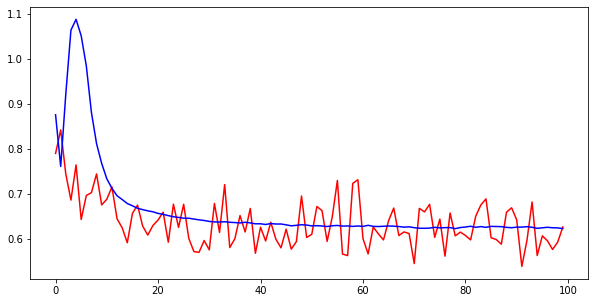

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses,'r')
plt.plot(val_losses, 'b')

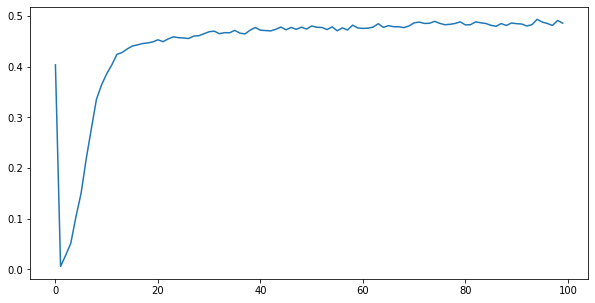

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(val_metrics)

## Evaluate

In [28]:
dl_test = torch.utils.data.DataLoader(
    DatasetTrain(df_val, transforms=test_transforms),
    shuffle=False, batch_size=batch_size, num_workers=2
    )

In [29]:
# net.load_state_dict(torch.load('model.pth'))
net.eval();

In [30]:
gt = []
predictions = []
with torch.no_grad():
    for imgs, labels, ids in tqdm(dl_test):
        output = net(imgs.cuda()).cpu().argmax(1)
        predictions += list(output.cpu().numpy())
        gt += list(labels.numpy())

100%|██████████| 34/34 [00:04<00:00,  7.13it/s]


In [31]:
f1_score(predictions, gt)

0.49423963133640547

In [32]:
from sklearn.metrics import classification_report

print(classification_report(gt, predictions))

              precision    recall  f1-score   support

           0       0.87      0.54      0.66      1616
           1       0.36      0.77      0.49       556

    accuracy                           0.60      2172
   macro avg       0.62      0.65      0.58      2172
weighted avg       0.74      0.60      0.62      2172



## Prepare test submissions

In [33]:
df = pd.read_csv('Test.csv')
df['Label'] = 1

In [34]:
df = transform_table(df)
df.head()

,Sample_ID,cell,Label,aspect,elevation,geology,lsfactor,placurv,procurv,sdoif,slope,twi
0,10865,1,1,240.9454,111.0,2.0,9.667106,0.035766,-0.016483,1.310570,45.83452,2.682646
1,10865,2,1,254.0546,109.0,2.0,8.181493,-0.013152,-0.044767,1.310638,36.05503,4.814003
2,10865,3,1,281.3099,109.0,2.0,7.782584,-0.037572,-0.042420,1.310684,27.01712,6.252043
3,10865,4,1,315.0000,110.0,2.0,8.776177,-0.062401,-0.053476,1.310752,22.98977,6.667844
4,10865,5,1,348.6901,112.0,2.0,10.954420,-0.055791,-0.043530,1.310797,27.01712,6.602260


In [35]:
dl_test = torch.utils.data.DataLoader(
    DatasetTrain(df, transforms=test_transforms),
    shuffle=False, batch_size=batch_size, num_workers=2
    )

In [36]:
sample_ids = []
predictions = []
with torch.no_grad():
    for imgs, labels, ids in tqdm(dl_test):
        output = net(imgs.cuda()).cpu().argmax(1)
        predictions += list(output.cpu().numpy())
        sample_ids += list(ids.numpy())

100%|██████████| 85/85 [00:11<00:00,  7.27it/s]


In [37]:
df_out = pd.DataFrame(np.array([sample_ids, predictions]).transpose(),
                      columns=['Sample_ID', 'Label'])
df_out.head()

,Sample_ID,Label
0,10865,1
1,10866,1
2,10867,0
3,10868,0
4,10869,1


In [38]:
df_out.to_csv('submission_landslide.csv', index=False)

In [39]:
from google.colab import files
files.download('submission_landslide.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>